# Assignment 2

(Part of this exercise is based on https://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/)

## Sentiment Classification

This assignment approaches the sentiment classification problem by using deep learning techniques and also exposes some ethical problem related to these methods.

This is what we’re going to do:

+ Acquire some pre-computed word embeddings to represent the meanings of words
+ Acquire training and test data, with gold-standard examples of positive and negative words
+ Train a simple classifier to recognize other positive and negative words based on their word embeddings
+ Compute sentiment scores for sentences of text using this classifier
+ Analyze the results to look for unwanted bias. 

## Word embeddings

There are several datasets of pre-trained English word embeddings such as `word2vec`, pretrained on Google News data, and `GloVe`, pretrained on the Common Crawl of web pages. We will use `GloVe`.

GloVe comes in three sizes: 6B, 42B, and 840B. The 42B version is pretty good and is also neatly trimmed to a vocabulary of 1 million words. We will just use the 42B version.

> **GloVe.42B** data: 42B tokens, 1.9M vocab, uncased, 300d vectors, 1.75 GB download

In [ ]:
!pip install numpy==1.16.2

In [ ]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

--2019-04-30 10:14:03--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2019-04-30 10:14:03--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Saving to: ‘glove.42B.300d.zip’

glove.42B.300d.zip  100%[===================>]   1.75G  12.2MB/s    in 2m 50s  

2019-04-30 10:16:53 (10.5 MB/s) - ‘glove.42B.300d.zip’ saved [1877800501/1877800501]



In [ ]:
!unzip glove.42B.300d.zip
!rm glove.42B.300d.zip

Archive:  glove.42B.300d.zip
replace glove.42B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.42B.300d.txt      y



In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def load_embeddings(filename):
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in tqdm(enumerate(infile)):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('glove.42B.300d.txt')
embeddings.shape

1917494it [03:44, 8546.21it/s]


(1917494, 300)

## Positive and Negative Words

We need some input about which words are positive and which words are negative. There are many sentiment lexicons you could use, but we’re going to go with a very straightforward lexicon from https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html  

There is a copy of these files in the GitHub repository of the course.

In [ ]:
!wget https://raw.githubusercontent.com/DataScienceUB/DeepLearningMaster2019/master/data/positive-words.txt
!wget https://raw.githubusercontent.com/DataScienceUB/DeepLearningMaster2019/master/data/negative-words.txt


--2019-04-30 10:23:51--  https://raw.githubusercontent.com/DataScienceUB/DeepLearningMaster2019/master/data/positive-words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22408 (22K) [text/plain]
Saving to: ‘positive-words.txt.1’

positive-words.txt. 100%[===================>]  21.88K  --.-KB/s    in 0.008s  

2019-04-30 10:23:51 (2.61 MB/s) - ‘positive-words.txt.1’ saved [22408/22408]

--2019-04-30 10:23:53--  https://raw.githubusercontent.com/DataScienceUB/DeepLearningMaster2019/master/data/negative-words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting resp

In [ ]:
def load_lexicon(filename):
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('positive-words.txt')
neg_words = load_lexicon('negative-words.txt')

Some of these words are not in the GloVe vocabulary. Those words end up with rows full of NaN to indicate their missing embeddings, so we will use Pandas to clean the dataset.

In [ ]:
pos_vectors = embeddings.loc[pos_words].dropna()
neg_vectors = embeddings.loc[neg_words].dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


Now we make arrays of the desired inputs and outputs. The inputs are the embeddings, and the outputs are `1` for positive words and `-1` for negative words. We also make sure to keep track of the words they’re labeled with, so we can interpret the results.

In [ ]:
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [ ]:
from sklearn.model_selection import train_test_split

train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

Now it is time to make your classifier, and train it by running the training vectors through it for 100 iterations. You can use a logistic function as the loss, so that the resulting classifier can output the probability that a word is positive or negative.

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

model = SGDClassifier(loss='log', random_state=0, n_iter=100)
model.fit(train_vectors, train_targets)
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=100, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=100, n_iter_no_change=5, n_jobs=1, penalty='l2', power_t=0.5,
       random_state=0, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

We can evaluate the classifier on the test vectors. 


In [ ]:
accuracy_score(model.predict(test_vectors), test_targets)

0.9502262443438914

Let’s define a function that we can use to see the sentiment that this classifier predicts for particular words, then use it to see some examples of its predictions on the test data.

In [ ]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


# Show 20 examples from the test set
words_to_sentiment(test_labels).ix[:20]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,sentiment
fidget,-9.931679
interrupt,-9.634706
staunchly,1.466919
imaginary,-2.989215
taxing,0.468522
world-famous,6.908561
low-cost,9.237223
disapointment,-8.737182
totalitarian,-10.851580
bellicose,-8.328674


## Sentiment score for text

There are many ways to combine sentiments for word vectors into an overall sentiment score. The simplest way is to average them.

In [ ]:
import re
TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


def text_to_sentiment(text):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    sentiments = words_to_sentiment(tokens)
    return sentiments['sentiment'].mean()

In [ ]:
text_to_sentiment("this example is pretty cool")

3.889968926086298

In [ ]:
text_to_sentiment("meh, this example sucks")

-1.1774475917460698

Let’s see what it does with a few variations on a neutral sentence:

In [ ]:
print(text_to_sentiment("Let's go get Italian food"))
print(text_to_sentiment("Let's go get Chinese food"))
print(text_to_sentiment("Let's go get Indian food"))

2.0429166109408983
1.4094033658140972
1.5702502107020269


In [ ]:
print(text_to_sentiment("My name is Emily"))
print(text_to_sentiment("My name is Heather"))
print(text_to_sentiment("My name is Yvette"))
print(text_to_sentiment("My name is Shaniqua"))


2.228617936474531
1.3976291151079159
0.9846380213298556
-0.47048131775890656


The system has associated wildly different sentiments with people’s names. You can look at these examples and many others and see that the sentiment is generally more positive for stereotypically-white names, and more negative for stereotypically-black names.

## Ethical problem

We want to learn how to not make something like this again. So let’s put more data through it, and statistically measure how bad its bias is.

Here we have four lists of names that tend to reflect different ethnic backgrounds, mostly from a United States perspective. The first two are lists of predominantly “white” and “black” names adapted from Caliskan et al.’s article. I also added typically Hispanic names, as well as Muslim names that come from Arabic or Urdu; these are two more distinct groupings of given names that tend to represent your background.

In [ ]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    
    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Ayaan', 'Syed', 'Rishaan', 'Samar', 'Ahmad', 'Zikri', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
    ]
}

Now we’ll use Pandas to make a table of these names, their predominant ethnic background, and the sentiment score we get for them:

In [ ]:
def name_sentiment_table():
    frames = []
    for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

name_sentiments = name_sentiment_table()

name_sentiments.ix[::25]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stabl

,sentiment,group
mohammed,0.834974,Arab/Muslim
alya,3.916803,Arab/Muslim
terryl,-2.858010,Black
josé,0.432956,Hispanic
luciana,1.086073,Hispanic
hank,0.391858,White
megan,2.158679,White


(-10, 10)

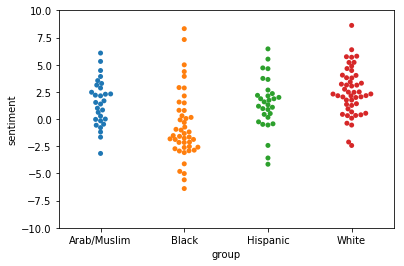

In [ ]:
import seaborn

plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)
plot.set_ylim([-10, 10])

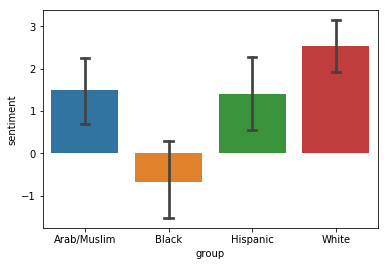

In [ ]:
plot = seaborn.barplot(x='group', y='sentiment', data=name_sentiments, capsize=.1)

# Exercise

We have used only word labels to build a sentiment classifier, but if we have sentence labels we can build a model that uses both, word and sentence information.

To this end, you can use the `imdb` dataset (available in Keras): https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py 

Yours tasks are:
+ Use the sentiment model we have already developed (based on words), to evaluate the `imdb` dataset. What is the accuracy of this classifier?


In [ ]:
#!pip install numpy==1.16.2

In [ ]:
#importing the data and spliting it into train and test set, determining max features
from keras.datasets import imdb
import pandas as pd

max_features = 20000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)


Treshold was determined by experimenting - The model or the data are probably biased towards positive words, so only if a word gets sentiment score of 1.55 or higher it's classified as positive (1).

In [ ]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
[(value, key) for (key, value) in word_index.items()])

def sequence_to_text(sequence):
    decoded_review = ' '.join(
    [reverse_word_index.get(i - 3, '?') for i in sequence])
    return decoded_review

def get_sentiment(sequence):
    score = text_to_sentiment(sequence_to_text(sequence))
    if score >= 1.55:
        return 1
    else:
        return 0 

In [ ]:
#quick check
print(text_to_sentiment('Titanic'))
print(get_sentiment(x_train[15]))

0.5424886970379013
0


In [ ]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

y_pred = np.array([get_sentiment(i) for i in x_train[:25000]])
accuracy_score(y_train[:25000], y_pred)

0.75232


+ Train a LSTM model to classify sentences based on the `imdb` dataset but, insteasd of learning specific embeddings for this problem, use `GloVe`.  What is the accuracy of this classifier?

(Changing the embedding to glove, getting the weight matrix and getting the embedding vectors for further analysis.)


In [ ]:
def load_embedding(filename):
	# load embedding into memory, skip first line
	file = open(filename,'r')
	lines = file.readlines()[1:]
	file.close()
	# create a map of words to vectors
	embedding = dict()
	for line in lines:
		parts = line.split()
		# key is string word, value is numpy array for vector
		embedding[parts[0]] = asarray(parts[1:], dtype='float32')
	return embedding

embeddings = load_embeddings('glove.42B.300d.txt')
embeddings.shape

1917494it [03:50, 8328.58it/s]


(1917494, 300)

In [ ]:
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

In [ ]:
embedding_vectors = embeddings[:max_features]
print(embedding_vectors.shape)
#print(embedding_vectors)

(20000, 300)
                    0         1         2         3         4         5    \
,              0.183780 -0.121230 -0.119870  0.015227 -0.191210 -0.066074   
the           -0.208380 -0.149320 -0.017528 -0.028432 -0.060104 -0.264600   
.              0.108760  0.002244  0.222130 -0.121020 -0.048959  0.018135   
and           -0.096110 -0.257880 -0.358600 -0.328870  0.579500 -0.517740   
to            -0.248370 -0.454610  0.039227 -0.284220 -0.031852  0.263550   
of            -0.036429 -0.285920  0.063387 -0.601220 -0.015309  0.073243   
a             -0.035835  0.778440 -0.518060  0.080682 -0.131730 -0.286060   
in             0.068507 -0.023344  0.282710 -0.402150  0.077815 -0.027003   
"             -0.048032 -0.691400 -0.219570  0.089568  0.284720 -1.053100   
is             0.113960  0.345030 -0.055064 -0.201920  0.208480 -0.096990   
for           -0.239090 -0.641890 -0.583220 -0.547430  0.423860 -0.117550   
:              0.185240 -0.378870  0.266030 -0.593010  0.655070

In [ ]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb



max_features = 20000
maxlen = 80
#batch_size = 32
batch_size = 1000
weights=embedding_vectors
embedding_layer = Embedding(max_features, 300, weights=[embedding_vectors])


(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)


x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)


model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test))

score, acc = model2.evaluate(x_test, y_test,
                            batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

y_pred2 = model2.predict(y_test)


#model.save('LSTM_model.h5')
#from keras.models import load_model
#modeL = load_model(LSTM_model.h5)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train...
Instructions for updating:
Use tf.cast instead.
Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 12s 470us/step - loss: 0.6768 - acc: 0.5650 - val_loss: 0.6450 - val_acc: 0.6214
Epoch 2/15
25000/25000 [==============================] - 10s 386us/step - loss: 0.5980 - acc: 0.6739 - val_loss: 0.5269 - val_acc: 0.7337
Epoch 3/15
25000/25000 [==============================] - 10s 385us/step - loss: 0.4917 - acc: 0.7598 - val_loss: 0.4330 - val_acc: 0.7992
Epoch 4/15
25000/25000 [==============================] - 10s 384us/step - loss: 0.4053 - acc: 0.8141 - val_loss: 0.3950 - val_acc:

##Hybrid model

+ Build and train a hybrid model for taking into account word and sentence labels. What is the accuracy of this classifier when applied the `imdb` dataset ?


In [ ]:
#using predictions from the first model - y_pred and predictions from
#the second model - y_pred2 and concatenating them together.
X = np.c_[y_pred,y_pred2]
y = y_test

array([[1.        , 0.38161117]])

In [ ]:
#splitting the previous test data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
#Applying neural network to newly created dataset. The accuracy of the hybrid
#model(model 3) is expected to be better than from the sentiment model(model 1) and 
#LSTM model (model 2)


batch_size = 32


model3a = Sequential([
    Dense(2, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# try using different optimizers and different optimizer configs
model3a.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model3a.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=15)
          #validation_data=(X_test, y_test))
      

score, acc = model3a.evaluate(X_test, y_test,
                            batch_size=batch_size)
                            

print('Test score:', score)
print('Test accuracy:', acc)


Epoch 1/15
20000/20000 [==============================] - 4s 176us/step - loss: 0.5784 - acc: 0.6882
Epoch 2/15
20000/20000 [==============================] - 3s 153us/step - loss: 0.4383 - acc: 0.7958
Epoch 3/15
20000/20000 [==============================] - 3s 154us/step - loss: 0.4262 - acc: 0.7958
Epoch 4/15
20000/20000 [==============================] - 3s 153us/step - loss: 0.4245 - acc: 0.7958
Epoch 5/15
20000/20000 [==============================] - 3s 154us/step - loss: 0.4243 - acc: 0.7958
Epoch 6/15
20000/20000 [==============================] - 3s 153us/step - loss: 0.4242 - acc: 0.7958
Epoch 7/15
20000/20000 [==============================] - 3s 152us/step - loss: 0.4242 - acc: 0.7958
Epoch 8/15
20000/20000 [==============================] - 3s 153us/step - loss: 0.4241 - acc: 0.7958
Epoch 9/15
20000/20000 [==============================] - 3s 154us/step - loss: 0.4241 - acc: 0.7958
Epoch 10/15
20000/20000 [==============================] - 3s 154us/step - loss: 0.4241 - a

In [ ]:
batch_size = 32


model3c = Sequential([
    Dense(2, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# try using different optimizers and different optimizer configs
model3c.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model3c.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=15)
          #validation_data=(X_test, y_test))
      

score, acc = model3c.evaluate(X_test, y_test,
                            batch_size=batch_size)
                            

print('Test score:', score)
print('Test accuracy:', acc)


Epoch 1/15
20000/20000 [==============================] - 4s 201us/step - loss: 0.6100 - acc: 0.6446
Epoch 2/15
20000/20000 [==============================] - 3s 168us/step - loss: 0.5235 - acc: 0.7068
Epoch 3/15
20000/20000 [==============================] - 3s 167us/step - loss: 0.5228 - acc: 0.7068
Epoch 4/15
20000/20000 [==============================] - 3s 167us/step - loss: 0.5224 - acc: 0.7068
Epoch 5/15
20000/20000 [==============================] - 3s 167us/step - loss: 0.5226 - acc: 0.7068
Epoch 6/15
20000/20000 [==============================] - 3s 168us/step - loss: 0.5225 - acc: 0.7068
Epoch 7/15
20000/20000 [==============================] - 3s 167us/step - loss: 0.4933 - acc: 0.7068
Epoch 8/15
20000/20000 [==============================] - 3s 167us/step - loss: 0.4108 - acc: 0.7062
Epoch 9/15
20000/20000 [==============================] - 3s 169us/step - loss: 0.4022 - acc: 0.7160
Epoch 10/15
20000/20000 [==============================] - 3s 167us/step - loss: 0.0752 - a

## PART 4

In [ ]:
imdb_words = imdb.get_word_index()
#search for the word in the dictionary to get it's key
vec = imdb_words['no']
#model2.predict(vec)


#Get imdb score, predict on it, calculate the mean of the sentence, if word is not in imdb, returns 0 for that word 

def get_sentiment_model2(text):
  words = text.split()
  vects = []
  for x in words:
    vec = imdb_words.get(x, 0)
    vects.append(vec)
 # print(vects)
  pred = model2.predict(vects)
  sentiment = np.mean(pred)
  return sentiment


0.55395913


In [ ]:
#model 1
print(text_to_sentiment('hello, my name is'))

#model 2
print(get_sentiment_model2('hello, my name is'))


2.304105891776296
0.55395913


In [ ]:
#model 3 hybrid predictions 
#model3.predict(([[1., 0.38161117]]))

#function that takes predictions of model1 and model 2 and returns predictions of model 3


#Apply the above function the the names